In [ ]:
!pip install transformers torchvision timm torch tqdm sentence-transformers

In [6]:
!pip install pillow-avif-plugin


In [7]:
from PIL import Image
import pillow_avif  # registers AVIF support
import os

# AVIF images
image_files = [
    'cat_1.avif', 'cat_2.avif', 'cat_3.avif', 'cat_4.avif',
    'dog_1.avif', 'dog_2.avif', 'dog_3.avif', 'dog_4.avif', 'dog_5.avif', 'dog_6.avif',
    'aquatic_1.avif','aquatic_4.avif','aquatic_5.avif', 'desserts_1.avif', 'desserts_2.avif', 'desserts_3.avif',
    'desserts_4.avif', 'mountains_1.avif',  'mountains_2.avif', 'mountains_3.avif'
]

# Output directory
output_dir = 'converted_images'
os.makedirs(output_dir, exist_ok=True)

# Convert each AVIF to JPG
for file in image_files:
    with Image.open(file) as img:
        img = img.convert("RGB")
        output_path = os.path.join(output_dir, file.replace('.avif', '.jpg'))
        img.save(output_path, format='JPEG')

print("[INFO] Conversion complete. Check 'converted_images/' folder.")


[INFO] Conversion complete. Check 'converted_images/' folder.


In [8]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import torch
import os
import json

image_directory = "converted_images"


print("Loading BLIP2 model...")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",
    torch_dtype=torch.float16
)


image_files = [f for f in os.listdir(image_directory)
               if os.path.isfile(os.path.join(image_directory, f))
               and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

print(f"Found {len(image_files)} images in the directory")


captions = {}


for image_file in image_files:
    full_image_path = os.path.join(image_directory, image_file)

    try:

        image = Image.open(full_image_path).convert("RGB")


        inputs = processor(images=image, return_tensors="pt").to(model.device)
        output = model.generate(**inputs, max_length=50)
        caption = processor.decode(output[0], skip_special_tokens=True)

        captions[image_file] = caption


        print(f"Image: {image_file}")
        print(f"Caption: {caption}")
        print("-" * 50)

    except Exception as e:
        print(f"Error processing {image_file}: {str(e)}")

with open('image_captions.json', 'w') as f:
    json.dump(captions, f, indent=2)

print(f"Processed {len(captions)} images. Captions saved to image_captions.json")

Loading BLIP2 model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Found 23 images in the directory
Image: mountains_1.jpg
Caption: the mountains are covered in snow at sunset

--------------------------------------------------
Image: cat_3.jpg
Caption: a jaguar is resting on a rock

--------------------------------------------------
Image: cloth_2.jpg
Caption: a man in a white t - shirt and black pants

--------------------------------------------------
Image: cat_4.jpg
Caption: a gray cat laying on top of a couch

--------------------------------------------------
Image: aquatic_5.jpg
Caption: a jellyfish on a blue background

--------------------------------------------------
Image: mountains_2.jpg
Caption: the mountain is covered in snow and clouds

--------------------------------------------------
Image: aquatic_2.jpg
Caption: a green tree frog sitting on a pink background

--------------------------------------------------
Image: dog_6.jpg
Caption: a wolf dog is standing in the snow

--------------------------------------------------
Image: dog

In [9]:
from sentence_transformers import SentenceTransformer
import json
import numpy as np
import pickle

print("Loading captions...")
with open('image_captions.json', 'r') as f:
    captions = json.load(f)

print(f"Loaded captions for {len(captions)} images")


print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')


image_files = list(captions.keys())
caption_texts = [captions[img] for img in image_files]


print("Generating embeddings...")
embeddings = model.encode(caption_texts, show_progress_bar=True)

embedding_dict = {}
for i, img_file in enumerate(image_files):
    embedding_dict[img_file] = embeddings[i]


with open('caption_embeddings.pkl', 'wb') as f:
    pickle.dump(embedding_dict, f)

print(f"Generated embeddings for {len(embedding_dict)} captions")
print(f"Embedding dimension: {embeddings[0].shape}")
print("Embeddings saved to caption_embeddings.pkl")

Loading captions...
Loaded captions for 23 images
Loading sentence transformer model...
Generating embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generated embeddings for 23 captions
Embedding dimension: (384,)
Embeddings saved to caption_embeddings.pkl


In [12]:
# import pickle
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# import json
# from PIL import Image
# import matplotlib.pyplot as plt
# import os

# # Load embeddings and captions
# print("Loading embeddings and captions...")
# with open('caption_embeddings.pkl', 'rb') as f:
#     embedding_dict = pickle.load(f)

# with open('image_captions.json', 'r') as f:
#     captions = json.load(f)

# # Path to the image directory - **CORRECT THIS PATH**
# # image_directory = "/path/to/your/uploaded/dataset"  # Update this path
# image_directory = "converted_images" # This should be the directory where you saved the converted images

# # Get list of images that have embeddings
# image_files = list(embedding_dict.keys())
# print(f"Calculating similarities among {len(image_files)} images")

# # Create embedding matrix for vectorized similarity calculation
# embedding_matrix = np.array([embedding_dict[img] for img in image_files])

# # Calculate cosine similarity matrix
# similarity_matrix = cosine_similarity(embedding_matrix)

# # Function to get similar images for a query image
# def get_similar_images(query_image, top_n=2):
#     if query_image not in embedding_dict:
#         print(f"Image {query_image} not found in the dataset")
#         return []

#     # Get index of the query image
#     query_idx = image_files.index(query_image)

#     # Get similarities with all images
#     similarities = similarity_matrix[query_idx]

#     # Get indices of the most similar images (excluding the query image itself)
#     # We first set the similarity with itself to -1 to exclude it
#     similarities_copy = similarities.copy()
#     similarities_copy[query_idx] = -1

#     # Get indices of top N similar images
#     top_indices = np.argsort(similarities_copy)[-top_n:][::-1]

#     # Return list of (image_file, similarity) tuples
#     similar_images = [(image_files[idx], similarities[idx]) for idx in top_indices]

#     return similar_images

# # Function to visualize query image and its similar images
# def visualize_similar_images(query_image, similar_images):
#     plt.figure(figsize=(15, 10))

#     # Display query image
#     plt.subplot(2, 3, 1)
#     img = Image.open(os.path.join(image_directory, query_image))
#     plt.imshow(img)
#     plt.title(f"Query: {query_image}\n{captions[query_image][:50]}...", fontsize=10)
#     plt.axis('off')

#     # Display similar images
#     for i, (img_file, similarity) in enumerate(similar_images):
#         plt.subplot(2, 3, i+2)
#         img = Image.open(os.path.join(image_directory, img_file))
#         plt.imshow(img)
#         plt.title(f"Similar {i+1}: {img_file}\nSim: {similarity:.4f}\n{captions[img_file][:50]}...",
#                   fontsize=10)
#         plt.axis('off')

#     plt.tight_layout()
#     plt.savefig('similar_images.png')
#     plt.show()

# # Example: Find and visualize similar images for the first image in the dataset
# for query_image in image_files:
#     print(f"\nFinding images similar to: {query_image}")
#     print(f"Caption: {captions[query_image]}")

#     similar_images = get_similar_images(query_image, top_n=2)

#     print("\nMost similar images:")
#     for img, sim in similar_images:
#         print(f"{img} (Similarity: {sim:.4f})")
#         print(f"Caption: {captions[img]}")
#         print("-" * 50)

#     visualize_similar_images(query_image, similar_images)

# # Interactive query function
# def query_similar_images():
#     print("\nEnter image filename to find similar images (or 'exit' to quit):")
#     while True:
#         query = input("> ")
#         if query.lower() == 'exit':
#             break

#         if query not in embedding_dict:
#             print(f"Image '{query}' not found. Available images:")
#             # Show some available images
#             for img in list(embedding_dict.keys())[:5]:
#                 print(f"- {img}")
#             print(f"... and {len(embedding_dict)-5} more")
#             continue

#         similar = get_similar_images(query, top_n=2)
#         visualize_similar_images(query, similar)

# # Uncomment to use interactive query
# # query_similar_images()

Loading embeddings and captions...
Calculating similarities among 23 images

🔍 Query Image: dog_6.jpg
📄 Caption: a wolf dog is standing in the snow

1. dog_5.jpg (Similarity: 0.9701)
   Caption: a wolf is standing in the snow

--------------------------------------------------
2. dog_4.jpg (Similarity: 0.5558)
   Caption: two wolf cubs playing in the snow

--------------------------------------------------


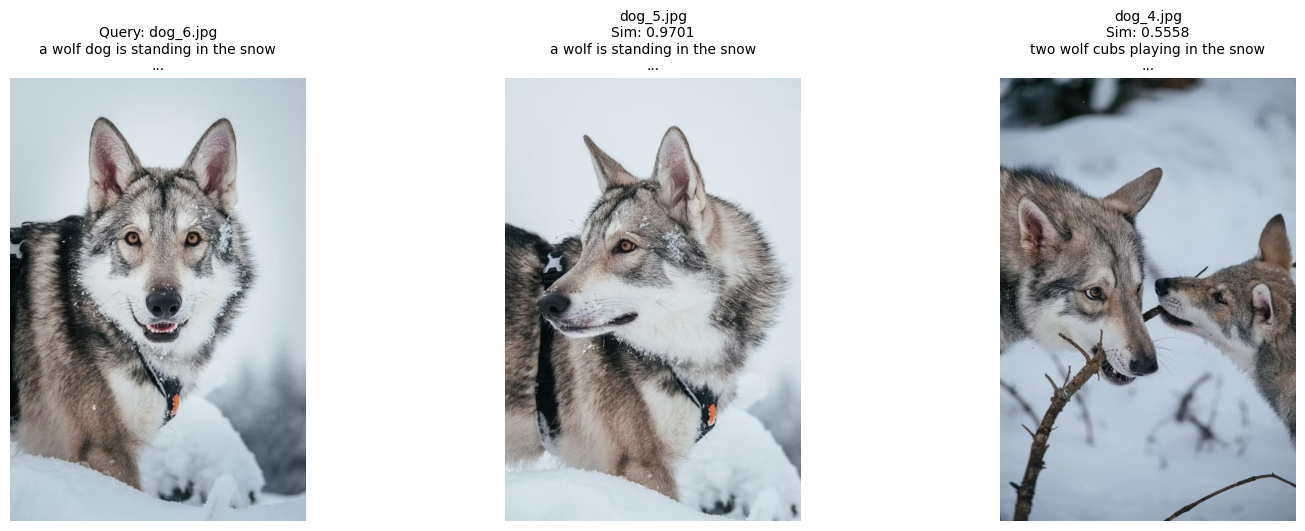


🔍 Query Image: desserts_3.jpg
📄 Caption: a cupcake with white frosting and blue sprinkles

1. desserts_2.jpg (Similarity: 0.6603)
   Caption: three chocolate cupcakes with cream cheese frosting and caramel

--------------------------------------------------
2. desserts_4.jpg (Similarity: 0.3058)
   Caption: a person holding a purple and blue donut

--------------------------------------------------


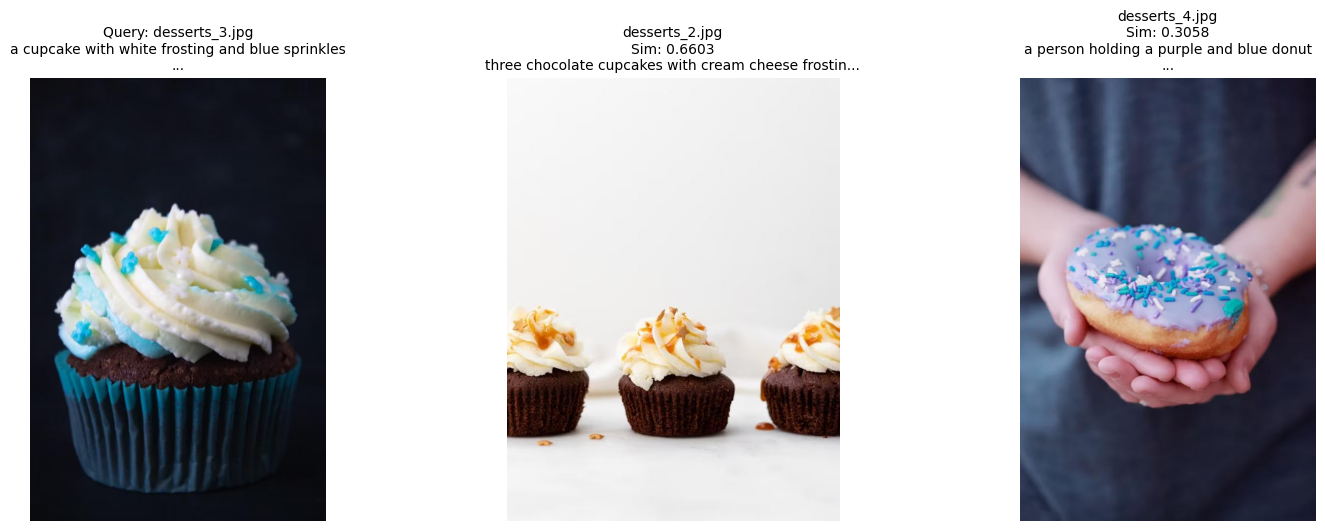


🔍 Query Image: mountains_1.jpg
📄 Caption: the mountains are covered in snow at sunset

1. mountains_2.jpg (Similarity: 0.7180)
   Caption: the mountain is covered in snow and clouds

--------------------------------------------------
2. mountains_3.jpg (Similarity: 0.5239)
   Caption: aerial view of the dolomites mountains in the evening

--------------------------------------------------


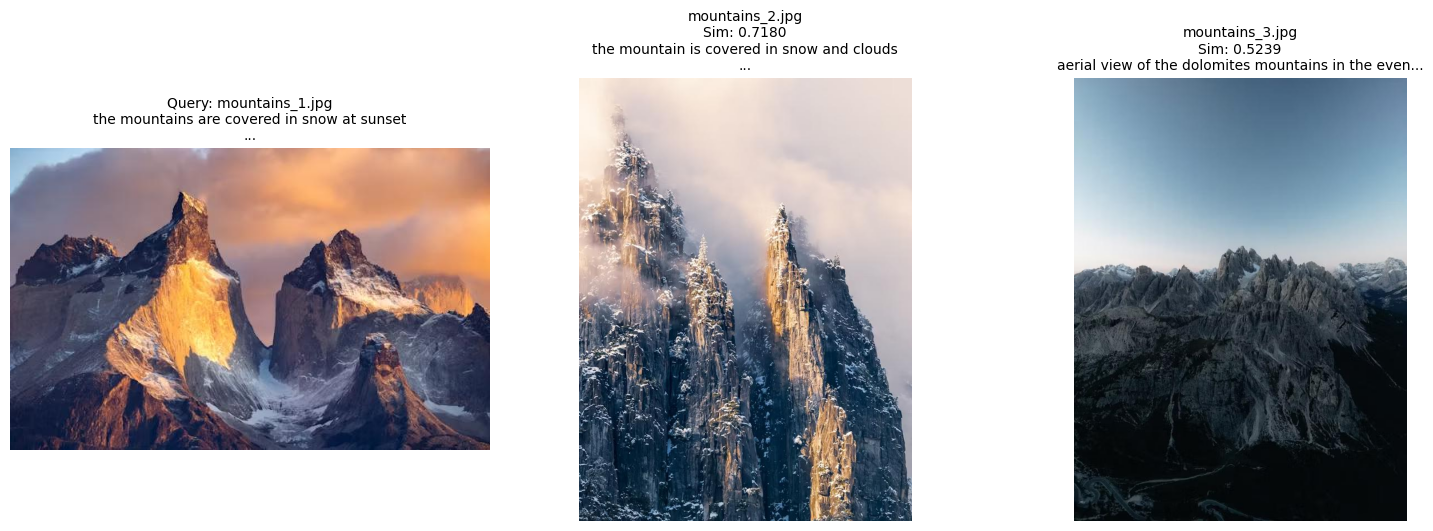


🔍 Query Image: aquatic_5.jpg
📄 Caption: a jellyfish on a blue background

1. aquatic_4.jpg (Similarity: 0.8289)
   Caption: a jellyfish floating in the dark with a blue light

--------------------------------------------------
2. aquatic_1.jpg (Similarity: 0.4772)
   Caption: a blue ray fish swimming in an aquarium

--------------------------------------------------


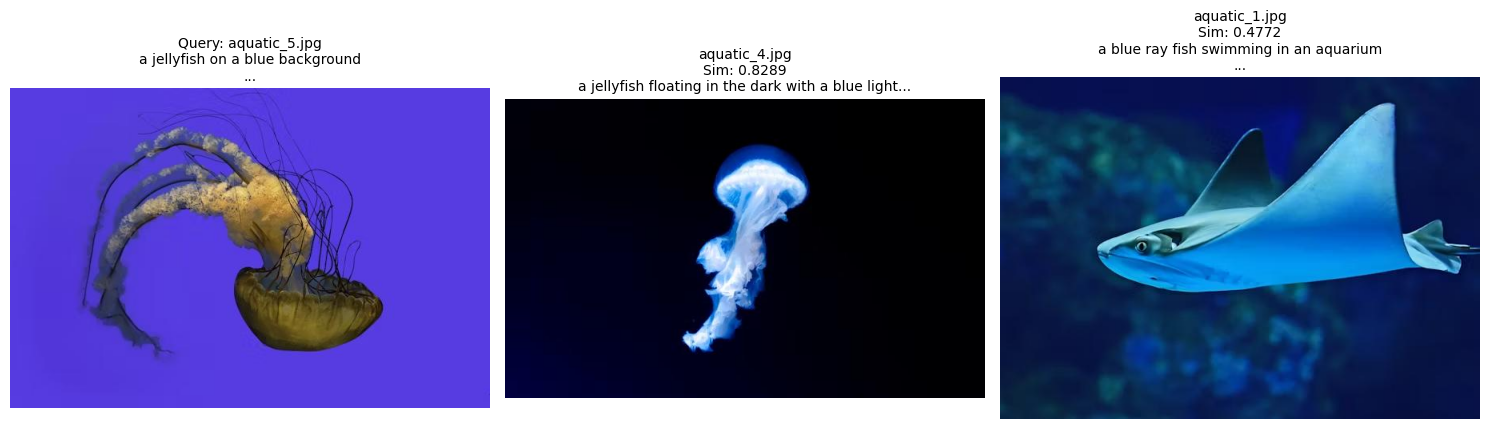

In [18]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from PIL import Image
import matplotlib.pyplot as plt
import os


print("Loading embeddings and captions...")
with open('caption_embeddings.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

with open('image_captions.json', 'r') as f:
    captions = json.load(f)


image_directory = "converted_images"


image_files = list(embedding_dict.keys())
print(f"Calculating similarities among {len(image_files)} images")


embedding_matrix = np.array([embedding_dict[img] for img in image_files])
similarity_matrix = cosine_similarity(embedding_matrix)

def get_similar_images(query_image, top_n=5):
    if query_image not in embedding_dict:
        print(f"Image {query_image} not found in the dataset")
        return []

    query_idx = image_files.index(query_image)
    similarities = similarity_matrix[query_idx]
    similarities[query_idx] = -1  # exclude itself
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    return [(image_files[idx], similarities[idx]) for idx in top_indices]


def visualize_similar_images(query_image, similar_images):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    img = Image.open(os.path.join(image_directory, query_image))
    plt.imshow(img)
    plt.title(f"Query: {query_image}\n{captions[query_image][:50]}...", fontsize=10)
    plt.axis('off')

    for i, (img_file, similarity) in enumerate(similar_images):
        plt.subplot(2, 3, i+2)
        img = Image.open(os.path.join(image_directory, img_file))
        plt.imshow(img)
        plt.title(f"{img_file}\nSim: {similarity:.4f}\n{captions[img_file][:50]}...", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --------- NEW PART: Run queries for different categories ---------
query_keywords = ["dog", "desserts_3.jpg", "mountain", "aquatic"]
query_images = []

# Auto-select 1 image for each keyword
for keyword in query_keywords:
    found = False
    for img_name in image_files:
        if keyword.lower() in img_name.lower():
            query_images.append(img_name)
            found = True
            break
    if not found:
        print(f"⚠️ No image found for keyword: {keyword}")


for query_img in query_images:
    print("=" * 80)
    print(f"\n🔍 Query Image: {query_img}")
    print(f"📄 Caption: {captions.get(query_img, 'No caption available')}")

    similar_imgs = get_similar_images(query_img, top_n=2)
    for idx, (sim_img, sim_score) in enumerate(similar_imgs, 1):
        print(f"{idx}. {sim_img} (Similarity: {sim_score:.4f})")
        print(f"   Caption: {captions.get(sim_img, 'No caption')}")
        print("-" * 50)

    visualize_similar_images(query_img, similar_imgs)
